## This experiment was performed using LightFM which a very popular recommender module and it has support to take in different data modalities such as text, image, graphical, etc. Please check out their official documentation in the link mentioned below:  
Link to LightFM:
making.lyst.com/lightfm/docs/home.html  

It also incorporates Multiprocessing to process predictions for final users

Please refer to the previous notebooks for different alterations. Summary of the alterations:  
1. Train Light FM without making use of any customer or article based feature on whole dataset. --> (https://www.kaggle.com/rickykonwar/h-m-lightfm-nofeatures)  
2. Train Light FM by making use of 1 article based feature on whole dataset --> Current Version  
3. Train Light FM by making use of 2 article based feature on whole dataset --> To Do
4. Train Light FM by making use of multiple article based features and also 1 customer based feature on whole dataset --> To Do

Hope you like this notebook, please feel free to vote for this notebook

## Importing Required Libraries

In [1]:
# Importing Libraries
import sys, os
import re
import tqdm
import time
import pickle
import random
import itertools

import pandas as pd
import numpy as np
import scipy.sparse as sparse
%matplotlib inline
import matplotlib.pyplot as plt

# lightfm 
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split

# multiprocessing for inferencing
from multiprocessing import Pool

In [2]:
os.environ["openblas_set_num_threads"] = "1"
data_path = r'../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
articles_data_path = r'../input/h-and-m-personalized-fashion-recommendations/articles.csv'
submission_data_path = r'../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'

In [3]:
# Data Extraction
def create_data(datapath):
    df=pd.read_csv(datapath)
    return df

In [4]:
# Loal all sales data (for 3 years starting from 2018 to 2020)
transactions_data=create_data(data_path)
print(transactions_data.shape)

articles_data=create_data(articles_data_path)
print(articles_data.shape)

(31788324, 5)
(105542, 25)


In [5]:
transactions_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [6]:
transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [7]:
articles_data.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [8]:
articles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [9]:
# Unique Attributes
print(str(len(transactions_data['t_dat'].drop_duplicates())) + "-total No of unique transactions dates in data sheet")
print(str(len(transactions_data['customer_id'].drop_duplicates())) + "-total No of unique customers ids in data sheet")
print(str(len(transactions_data['article_id'].drop_duplicates())) + "-total No of unique article ids courses names in data sheet")
print(str(len(transactions_data['sales_channel_id'].drop_duplicates())) + "-total No of unique sales channels in data sheet")

print('--------------------------------')

print(str(len(articles_data['article_id'].drop_duplicates())) + "-total No of unique article ids in article data sheet")
print(str(len(articles_data['product_group_name'].drop_duplicates())) + "-total No of unique product group names in article data sheet")

734-total No of unique transactions dates in data sheet
1362281-total No of unique customers ids in data sheet
104547-total No of unique article ids courses names in data sheet
2-total No of unique sales channels in data sheet
--------------------------------
105542-total No of unique article ids in article data sheet
19-total No of unique product group names in article data sheet


In [10]:
# Unique Product Group Names
articles_data['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

## Aggregating Customers and Articles irrespective of transaction dates

In [11]:
transactions_data = transactions_data.groupby(['customer_id','article_id']).agg({'price':'sum','t_dat':'count'}).reset_index()
transactions_data = transactions_data[['customer_id','article_id','price']]
transactions_data.shape

(27306439, 3)

In [12]:
transactions_data.head()

,customer_id,article_id,price
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,0.035576
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,0.101661
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,0.050831
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,0.012695
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,0.044051


## Merging transaction data with articles group name data

In [13]:
# Combine article's product group name with transaction's data
merged_transactions_data = pd.merge(left=transactions_data, right=articles_data[['article_id','product_group_name']], how='left', on='article_id')
merged_transactions_data.shape

(27306439, 4)

In [14]:
merged_transactions_data.head()

,customer_id,article_id,price,product_group_name
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,0.035576,Garment Upper body
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,0.101661,Garment Upper body
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,0.050831,Garment Upper body
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,0.012695,Garment Upper body
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,0.044051,Garment Upper body


In [15]:
merged_transactions_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27306439 entries, 0 to 27306438
Data columns (total 4 columns):
 #   Column              Dtype  
---  ------              -----  
 0   customer_id         object 
 1   article_id          int64  
 2   price               float64
 3   product_group_name  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.0+ GB


## Generating user and article index mapping dictionaries

In [16]:
def get_customers_list():
    # Creating a list of users
    return np.sort(merged_transactions_data['customer_id'].unique())

def get_articles_list():
    # Creating a list of courses 
    item_list = merged_transactions_data['article_id'].unique()
    return item_list

def get_feature_list():
    # Creating a list of features
    feature_list = merged_transactions_data['product_group_name'].unique()
    return feature_list

def id_mappings(customers_list, articles_list, feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    customer_to_index_mapping = {}
    index_to_customer_mapping = {}
    for customer_index, customer_id in enumerate(customers_list):
        customer_to_index_mapping[customer_id] = customer_index
        index_to_customer_mapping[customer_index] = customer_id
        
    article_to_index_mapping = {}
    index_to_article_mapping = {}
    for article_index, article_id in enumerate(articles_list):
        article_to_index_mapping[article_id] = article_index
        index_to_article_mapping[article_index] = article_id
    
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
    return customer_to_index_mapping, index_to_customer_mapping, \
           article_to_index_mapping, index_to_article_mapping, \
           feature_to_index_mapping, index_to_feature_mapping

In [17]:
# Create customer, article and feature lists
customers = get_customers_list()
articles = get_articles_list()
features = get_feature_list()

In [18]:
customers

array(['00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
       '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa',
       '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318',
       ...,
       'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264',
       'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a',
       'ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241'],
      dtype=object)

In [19]:
articles

array([176209023, 568601006, 568601043, ..., 618853001, 533932004,
       568499001])

In [20]:
features

array(['Garment Upper body', 'Garment Lower body', 'Accessories',
       'Garment Full body', 'Swimwear', 'Underwear', 'Shoes', 'Unknown',
       'Socks & Tights', 'Nightwear', 'Items', 'Bags',
       'Underwear/nightwear', 'Furniture', 'Garment and Shoe care',
       'Cosmetic', 'Interior textile', 'Stationery', 'Fun'], dtype=object)

In [21]:
# Generate mapping, LightFM library can't read other than (integer) index
customer_to_index_mapping, index_to_customer_mapping, \
article_to_index_mapping, index_to_article_mapping, \
feature_to_index_mapping, index_to_feature_mapping = id_mappings(customers, articles, features)

## Generate Customer Article Interaction Matrix

In [22]:
def get_customer_article_interaction(customer_article_amt_df):
    #start indexing
    customer_article_amt_df["customer_id"] = customer_article_amt_df["customer_id"]
    customer_article_amt_df["article_id"] = customer_article_amt_df["article_id"]
    customer_article_amt_df["price"] = customer_article_amt_df["price"]

    # Preprocessing dataframe created
    customer_article_amt_df = customer_article_amt_df.rename(columns = {"price":"total_amount_spent"})

    # Replace Amount Column with category codes 
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].astype('category')
    customer_article_amt_df['total_amount_spent'] = customer_article_amt_df['total_amount_spent'].cat.codes

    return customer_article_amt_df

def get_interaction_matrix(df, df_column_as_row, df_column_as_col, 
                        df_column_as_value, row_indexing_map, col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

def get_article_feature_interaction(article_product_group_df, product_group_brand_weight = 1):
    # drop duplicates
    article_product_group_df = article_product_group_df.drop_duplicates()

    # start indexing
    article_product_group_df["article_id"] = article_product_group_df["article_id"]
    article_product_group_df["product_group_name"] = article_product_group_df["product_group_name"]

    # allocate "product_group_name" into one column as "feature"
    article_product_group_df = article_product_group_df[["article_id", "product_group_name"]].rename(columns = {"product_group_name" : "feature_01"})
    article_product_group_df["feature_count"] = product_group_brand_weight # adding weight to feature
        
    # grouping for summing over feature_count
    article_product_group_df = article_product_group_df.groupby(["article_id", "feature_01"], as_index = False)["feature_count"].sum()
    
    return article_product_group_df


In [23]:
# Create customer and article interaction dataframe
customer_to_article = get_customer_article_interaction(customer_article_amt_df = transactions_data[['customer_id','article_id','price']])

# Create article and feature interaction dataframe
article_to_feature = get_article_feature_interaction(article_product_group_df = merged_transactions_data[['article_id','product_group_name']], 
                                                    product_group_brand_weight = 1)

print(customer_to_article.shape)   
print(article_to_feature.shape)

(27306439, 3)
(104547, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
customer_to_article.head()

,customer_id,article_id,total_amount_spent
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,8137
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,27464
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,12672
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,2052
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,10525


In [25]:
article_to_feature.head()

,article_id,feature_01,feature_count
0,108775015,Garment Upper body,1
1,108775044,Garment Upper body,1
2,108775051,Garment Upper body,1
3,110065001,Underwear,1
4,110065002,Underwear,1


In [26]:
# Generate customer_article_interaction_matrix for train data
customer_to_article_interaction = get_interaction_matrix(customer_to_article, "customer_id", "article_id", "total_amount_spent", \
                                                    customer_to_index_mapping, article_to_index_mapping)

# Generate article_to_feature interaction
article_to_feature_interaction = get_interaction_matrix(article_to_feature, "article_id", "feature_01",  "feature_count", \
                                                       article_to_index_mapping, feature_to_index_mapping)

In [27]:
customer_to_article_interaction

<1362281x104547 sparse matrix of type '<class 'numpy.int32'>'
	with 27306439 stored elements in COOrdinate format>

In [28]:
article_to_feature_interaction

<104547x19 sparse matrix of type '<class 'numpy.int64'>'
	with 104547 stored elements in COOrdinate format>

## Light FM Model Training

In [29]:
#### FULL MODEL TRAINING ####
# Retraining the final model with full dataset
"""
Training model without any article or customer features
"""
final_model_without_feature = LightFM(loss = "warp")

# Fitting to combined dataset with pure collaborative filtering result
start = time.time() 
final_model_without_feature.fit(customer_to_article_interaction,
                                user_features=None, 
                                item_features=None, 
                                sample_weight=None, 
                                epochs=1, 
                                num_threads=4, 
                                verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

"""
Training model with article feature (article's product_group_name)
"""
final_model_with_1_feature = LightFM(loss = "warp")

# Fitting to combined dataset with pure collaborative filtering result
start = time.time() 
final_model_with_1_feature.fit(customer_to_article_interaction,
                            user_features=None, 
                            item_features=article_to_feature_interaction, 
                            sample_weight=None, 
                            epochs=1, 
                            num_threads=4, 
                            verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 25.45 seconds
time taken = 23.93 seconds


## Recommendation sampling and Comparison with Known Positives

In [30]:
class recommendation_sampling():
    def __init__(self, model, items = None, user_to_product_interaction_matrix = None, 
                item_features = None, user2index_map = None):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.item_features = item_features if item_features is not None else None
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user, k=3, prediction_type = 'normal'):
        # Getting the userindex
        userindex = self.user2index_map.get(user, None)
        if userindex == None:
            print("User %s not provided during Training the model" %(user))
            return None
        
        # Products already bought
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # Scores from model prediction
        scores = self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)]
        
        # Printing out the result
        print("User %s" % user)
        print("     Known positives:")
        for x in known_positives[:k]:
            print("                  %s" % x)
            
        print("     Recommended:")
        for x in top_items[:k]:
            print("                  %s" % x)

    def get_recommendation(self, user, k=3, prediction_type = 'normal'):
        # Getting the userindex
        userindex = self.user2index_map.get(user, None)
        if userindex == None:
            return None
        
        # Products already bought
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # Scores from model prediction
        scores = self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = userindex, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
        
        # Top items
        top_items = self.items[np.argsort(-scores)]

        # Returning results
        recommended_list, recommender_count = [],1
        for item in top_items[:k]:
            recommended_list.append({'Priority': recommender_count,'Article': item})
            recommender_count+=1
        return known_positives, recommended_list
    
    def get_batched_recommendation(self, user, k=3, prediction_type='normal'):
        # Getting user_indexes 
        user_index = self.user2index_map.get(user, None)
        if user_index is None:
            return None
        
        # Scores from model
        scores = self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1])) if prediction_type == 'normal' else \
            self.model.predict(user_ids = user_index, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]), item_features = self.item_features)
    
        # Top items
        top_items = self.items[np.argsort(-scores)]
        
        return top_items[:k]

In [31]:
# Giving recommendations
recom_without_feature = recommendation_sampling(model = final_model_without_feature,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               user2index_map = customer_to_index_mapping)

recom_with_1_feature = recommendation_sampling(model = final_model_with_1_feature,
                                               items = articles,
                                               user_to_product_interaction_matrix = customer_to_article_interaction,
                                               item_features = article_to_feature_interaction,
                                               user2index_map = customer_to_index_mapping)

In [32]:
recom_without_feature.recommendation_for_user('00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657')
recom_without_feature.recommendation_for_user('0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa')
recom_without_feature.recommendation_for_user('000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318')
recom_without_feature.recommendation_for_user('00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e')
recom_without_feature.recommendation_for_user('00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a')

User 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
     Known positives:
                  176209023
                  568601006
                  568601043
     Recommended:
                  706016001
                  610776002
                  706016002
User 0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa
     Known positives:
                  351484002
                  377277001
                  478646001
     Recommended:
                  706016001
                  759871002
                  706016002
User 000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318
     Known positives:
                  351484002
                  723529001
                  541518023
     Recommended:
                  706016001
                  372860001
                  759871002
User 00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e
     Known positives:
                  732413001
                  742079001
     Recommended:


In [33]:
recom_with_1_feature.recommendation_for_user(user = '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e', prediction_type = 'feature')
recom_with_1_feature.recommendation_for_user(user = '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a', prediction_type = 'feature')

User 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
     Known positives:
                  176209023
                  568601006
                  568601043
     Recommended:
                  866244003
                  480093001
                  880553003
User 0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa
     Known positives:
                  351484002
                  377277001
                  478646001
     Recommended:
                  901955001
                  695043002
                  599580036
User 000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318
     Known positives:
                  351484002
                  723529001
                  541518023
     Recommended:
                  714029002
                  851780001
                  852678003
User 00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e
     Known positives:
                  732413001
                  742079001
     Recommended:


## MAP@12 Calculation for entire dataset

In [34]:
sparse_customer_article_train, sparse_customer_article_test = random_train_test_split(customer_to_article_interaction, test_percentage=0.2, random_state=42)

In [35]:
sparse_customer_article_train

<1362281x104547 sparse matrix of type '<class 'numpy.float32'>'
	with 21845151 stored elements in COOrdinate format>

In [36]:
sparse_customer_article_test

<1362281x104547 sparse matrix of type '<class 'numpy.float32'>'
	with 5461288 stored elements in COOrdinate format>

### Cross Validation methodolody

In [37]:
# Initialising model with warp loss function
model_with_1_feature = LightFM(loss = "warp")

# Fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()
model_with_1_feature.fit(sparse_customer_article_train,
                      user_features=None, 
                      item_features=article_to_feature_interaction, 
                      sample_weight=None, 
                      epochs=1, 
                      num_threads=4,
                      verbose=False)
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 20.77 seconds


### Writing Precision Calculation

In [38]:
# Precision metric score (ranging from 0 to 1)
k = 12
precision_with_1_article_feature = []
for precision_k in tqdm.tqdm(range(1,k+1), desc='Calculating Precisions at different k levels with 1 article feature'):
    start = time.time()
    precision_with_1_article_feature.append(precision_at_k(model = model_with_1_feature, 
                                                        test_interactions = sparse_customer_article_test,
                                                        item_features = article_to_feature_interaction,
                                                        num_threads = 4, 
                                                        k=precision_k,
                                                        check_intersections = False))
    end = time.time()
    print("Time taken for top %s number precision = %s seconds" %(str(precision_k), str(round(end-start,2))))

Calculating Precisions at different k levels with 1 article feature:   8%|▊         | 1/12 [30:49<5:39:00, 1849.17s/it]

Time taken for top 1 number precision = 1849.17 seconds


Calculating Precisions at different k levels with 1 article feature:  17%|█▋        | 2/12 [1:02:00<5:10:24, 1862.44s/it]

Time taken for top 2 number precision = 1871.73 seconds


Calculating Precisions at different k levels with 1 article feature:  25%|██▌       | 3/12 [1:32:56<4:38:53, 1859.27s/it]

Time taken for top 3 number precision = 1855.49 seconds


Calculating Precisions at different k levels with 1 article feature:  33%|███▎      | 4/12 [2:03:59<4:08:07, 1860.88s/it]

Time taken for top 4 number precision = 1863.36 seconds


Calculating Precisions at different k levels with 1 article feature:  42%|████▏     | 5/12 [2:34:59<3:37:02, 1860.31s/it]

Time taken for top 5 number precision = 1859.3 seconds


Calculating Precisions at different k levels with 1 article feature:  50%|█████     | 6/12 [3:06:07<3:06:18, 1863.08s/it]

Time taken for top 6 number precision = 1868.44 seconds


Calculating Precisions at different k levels with 1 article feature:  58%|█████▊    | 7/12 [3:37:05<2:35:06, 1861.30s/it]

Time taken for top 7 number precision = 1857.62 seconds


Calculating Precisions at different k levels with 1 article feature:  67%|██████▋   | 8/12 [4:08:10<2:04:10, 1862.73s/it]

Time taken for top 8 number precision = 1865.78 seconds


Calculating Precisions at different k levels with 1 article feature:  75%|███████▌  | 9/12 [4:39:13<1:33:07, 1862.62s/it]

Time taken for top 9 number precision = 1862.4 seconds


Calculating Precisions at different k levels with 1 article feature:  83%|████████▎ | 10/12 [5:10:19<1:02:07, 1863.61s/it]

Time taken for top 10 number precision = 1865.82 seconds


Calculating Precisions at different k levels with 1 article feature:  92%|█████████▏| 11/12 [5:41:15<31:01, 1861.42s/it]  

Time taken for top 11 number precision = 1856.44 seconds


Calculating Precisions at different k levels with 1 article feature: 100%|██████████| 12/12 [6:12:15<00:00, 1861.31s/it]

Time taken for top 12 number precision = 1860.12 seconds


## Screenshot of precision evaluation  

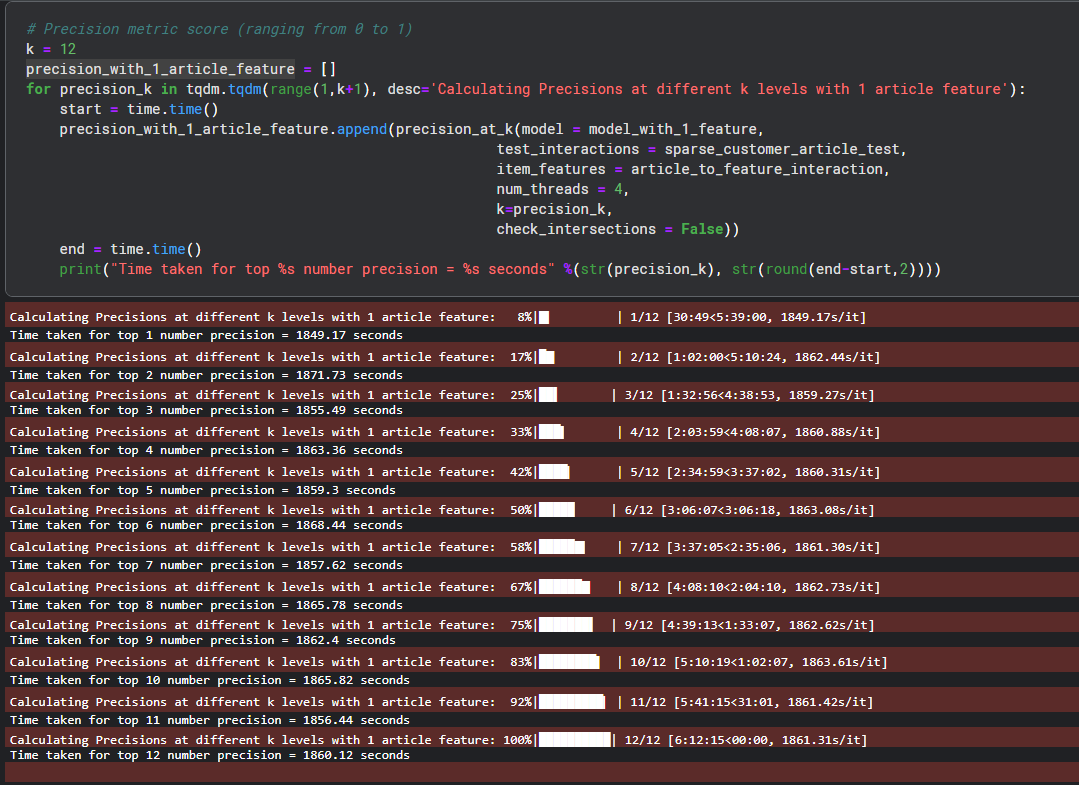

In [39]:
from numpy import save
save('./precision_with_1_article_feature.npy', precision_with_1_article_feature)

In [ ]:
precision_without_features = np.load('../input/hm-trained-models/lightfm_nofeatures/precision_without_features.npy')

### Calculating Average Precision@12

In [40]:
map_12 = np.sum(precision_with_1_article_feature, axis=0) / 12

### Calculating Mean Average Precision

In [45]:
print("average precision @ 12 by adding 1 article-feature interaction = {0:.{1}f}".format(map_12.mean(), 3)) 

average precision @ 12 by adding 1 article-feature interaction = 0.000


## Saving Final Model with any feature

In [44]:
with open('model_with_1_article_feature.pickle', 'wb') as fle:
    pickle.dump(final_model_with_1_feature, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Getting Predictions based on submission template

In [46]:
submission_data = pd.read_csv(submission_data_path)
submission_data.shape

(1371980, 2)

In [47]:
submission_data.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [48]:
submission_data.loc[submission_data.customer_id.isin([submission_data.customer_id.unique()[0]])].prediction[0].split(' ')

['0706016001',
 '0706016002',
 '0372860001',
 '0610776002',
 '0759871002',
 '0464297007',
 '0372860002',
 '0610776001',
 '0399223001',
 '0706016003',
 '0720125001',
 '0156231001']

In [50]:
def create_chunk_indices(meta_df, chunk_idx, chunk_size):
    '''
    Function to generate chunks of data for multiprocessing
    '''
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    meta_chunk = meta_df[start_idx:end_idx]
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(meta_chunk))
    #chunk_idx in return value is used to sort the processed chunks back into original order,
    return (meta_chunk, chunk_idx)

In [51]:
def predict_sub_chunks(chunk):
    final_submission=[]
    for row in tqdm.tqdm(chunk[0].values):
        try:
            preds = recom_without_feature.get_batched_recommendation(user = row[0], k = 12, prediction_type = 'feature')
            if preds is not None:
                final_submission.append(' '.join(map(str, preds)))
            else:
                final_submission.append(row[1])
        except Exception as ex:
            print(ex)
    return final_submission

In [52]:
num_cores=4

def predict_submission(submission_data=None):
    #splitting here by measurement id's to get all signals for a measurement into single chunk
    customer_ids = submission_data["customer_id"].unique()
    df_split = np.array_split(customer_ids, num_cores)
    chunk_size = len(df_split[0])
    
    chunk1 = create_chunk_indices(submission_data, 0, chunk_size)
    chunk2 = create_chunk_indices(submission_data, 1, chunk_size)
    chunk3 = create_chunk_indices(submission_data, 2, chunk_size)
    chunk4 = create_chunk_indices(submission_data, 3, chunk_size)
    
    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1, chunk2, chunk3, chunk4]
    
    pool = Pool(num_cores)
    result = pool.map(predict_sub_chunks, all_chunks)
    
    result_combined = list(itertools.chain(result[0], result[1], result[2], result[3]))
    return result_combined

### The inferencing is done for first 1024 users in the sample file however you can find the complete prediction file in the dataset:  
LightFM dataset link: https://www.kaggle.com/rickykonwar/hm-trained-models

In [53]:
final_predictions = predict_submission(submission_data[:1024])

start/end 1:0,256
256
start/end 2:256,512
256
start/end 3:512,768
256
start/end 4:768,1024
256


100%|██████████| 256/256 [00:07<00:00, 36.35it/s]


In [54]:
len(final_predictions)

1024

## Writing Intermediate Predictions

In [55]:
final_submission_data = submission_data.copy()[:1024]
final_submission_data['prediction'] = final_predictions

In [56]:
final_submission_data.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,706016001 610776002 706016002 759871002 372860...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,706016001 759871002 706016002 372860001 720125...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,706016001 372860001 759871002 610776002 706016...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,706016001 372860001 706016002 610776002 759871...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,706016001 610776002 706016002 372860001 759871...


In [57]:
final_submission_data.to_csv("intermediate_submission.csv", index=False)

In [58]:
from IPython.display import FileLink
FileLink(r'intermediate_submission.csv')

/kaggle/working/intermediate_submission.csv

## Writing Complete Predictions

In [59]:
actual_submission_data = pd.read_csv(r'../input/hm-trained-models/lightfm_nofeatures/submission.csv')
actual_submission_data.to_csv("submission.csv", index=False)

In [60]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv